In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

# Load data and do some preprocessing

In [3]:
df = pd.DataFrame({k: np.squeeze(v) for k, v in np.load('../data/170103.npz').iteritems()})

In [4]:
df.columns

Index(['baseline', 'correct', 'decided', 'network', 'noise', 'runnerup_err',
       'runnerup_highest_err', 'scale', 'seed',
       'share_thresholding_intercepts', 't', 'target_sep', 'winner_err'],
      dtype='object')

In [5]:
abbrev = {'UsherMcClelland': 'UMcC', 'DriftDiffusion': 'DD'}
df['condition'] = df.apply(lambda x: '{}, {}, {}'.format(
    abbrev[x['network']], x['scale'], x['share_thresholding_intercepts']), axis=1)
cond_order = ['UMcC, 1.0, False', 'DD, 1.0, False', 'DD, 0.15, False', 'DD, 1.0, True', 'DD, 0.15, True']

In [6]:
dfd = df.query('decided == True')

# Plotting conventions

The optimal value will be marked by a blue horizontal line in each plot.

# Fraction of successful decisions

In all trials the network is given 1s to settle for a winner and it is supposed to output the winner for another 1s. A trial is counted as successful decision if the largest output dimension does not change in the interval from 1s to 2s and this output is at least 0.2.

Ideally we would get a decision in each trial, but we find the the Usher-McClelland network does not settle to a single decision all the time. If we scale down the input to the drift diffusion network it will "fail" to come to a decision within the alloted time, but given more time it should settle on a winner.

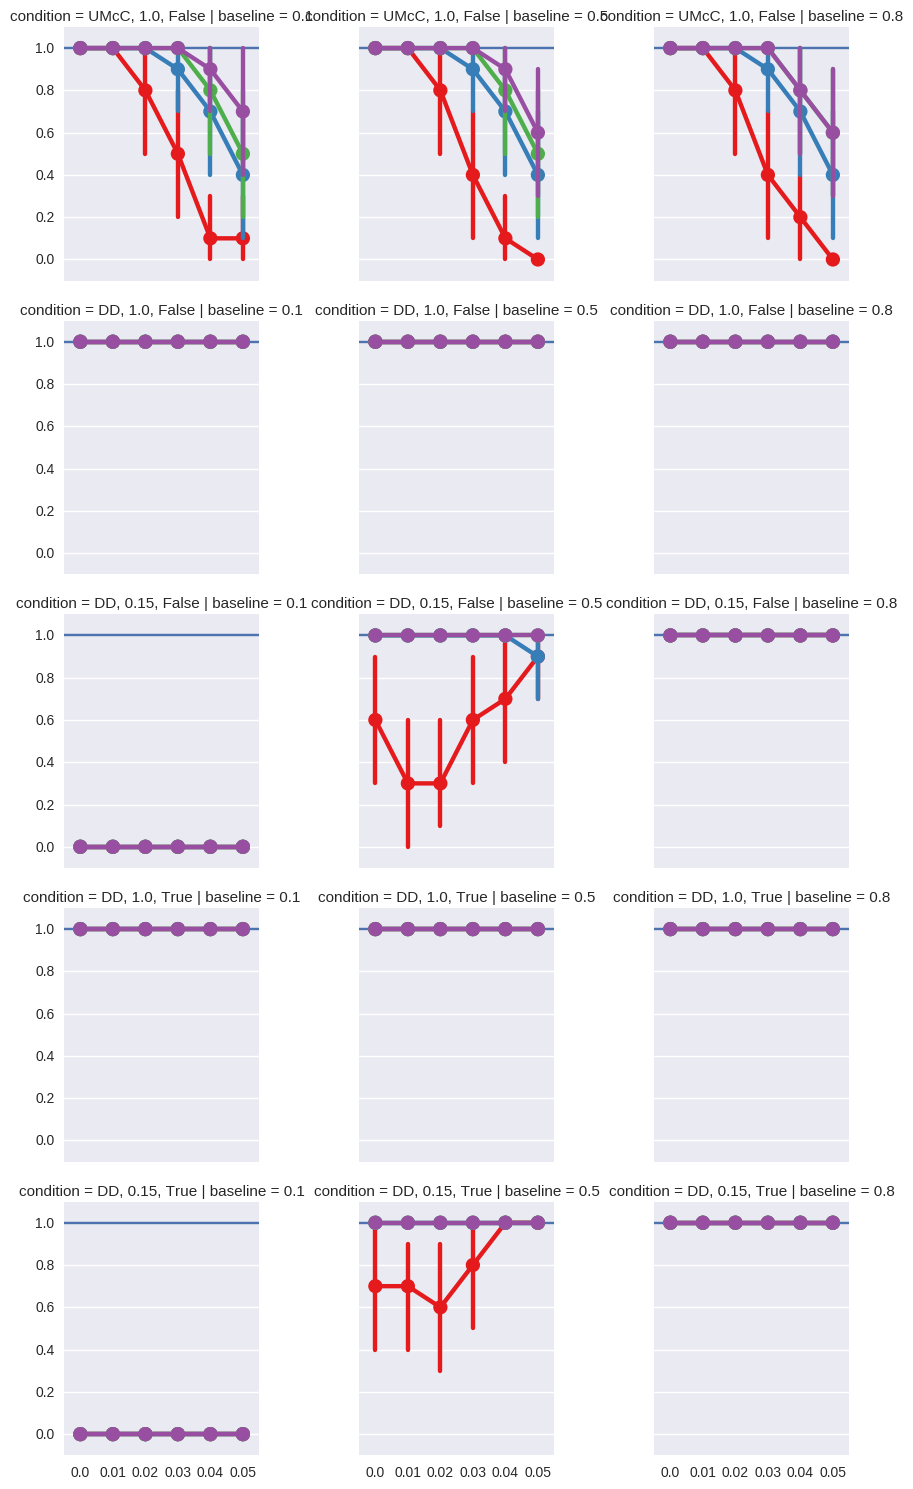

In [7]:
g = sns.FacetGrid(df, row='condition', col='baseline', row_order=cond_order)
g.map(sns.pointplot, 'noise', 'decided', 'target_sep', palette='Set1')
g.map(plt.axhline, y=1.)
g.set(ylim=(-0.1, 1.1))

# Fraction of correct trials

A trial is considered correct if the network setteled for a decision (see above) and it decided for the largest input.

Looking at the second row, the drift diffusion network seems to perform worse than the Usher-McClelland network, at least under noisy conditions. This is to some degree to the scaling of the input. With a scaling of 1 the drift diffusion network will not utilize most of the 1s decision period because it integrates much faster to threshold. Reducing the input scaling to 0.15 improves the results and for adequate target separation it will outperform the Usher-McClelland network. However, for small inputs (up to 0.3) the drift diffusion network will not reach a decision within the alloted time (but would likely do so given more time). We can improve the drift diffusion even slightly further by using the same intercepts for all thresholding ensembles. Not doing this introduces a systematic bias towards certain choices because the effective threshold values will slightly differ. However, doing this might not be biological plausible as it requires a precise tuning globally across the network.

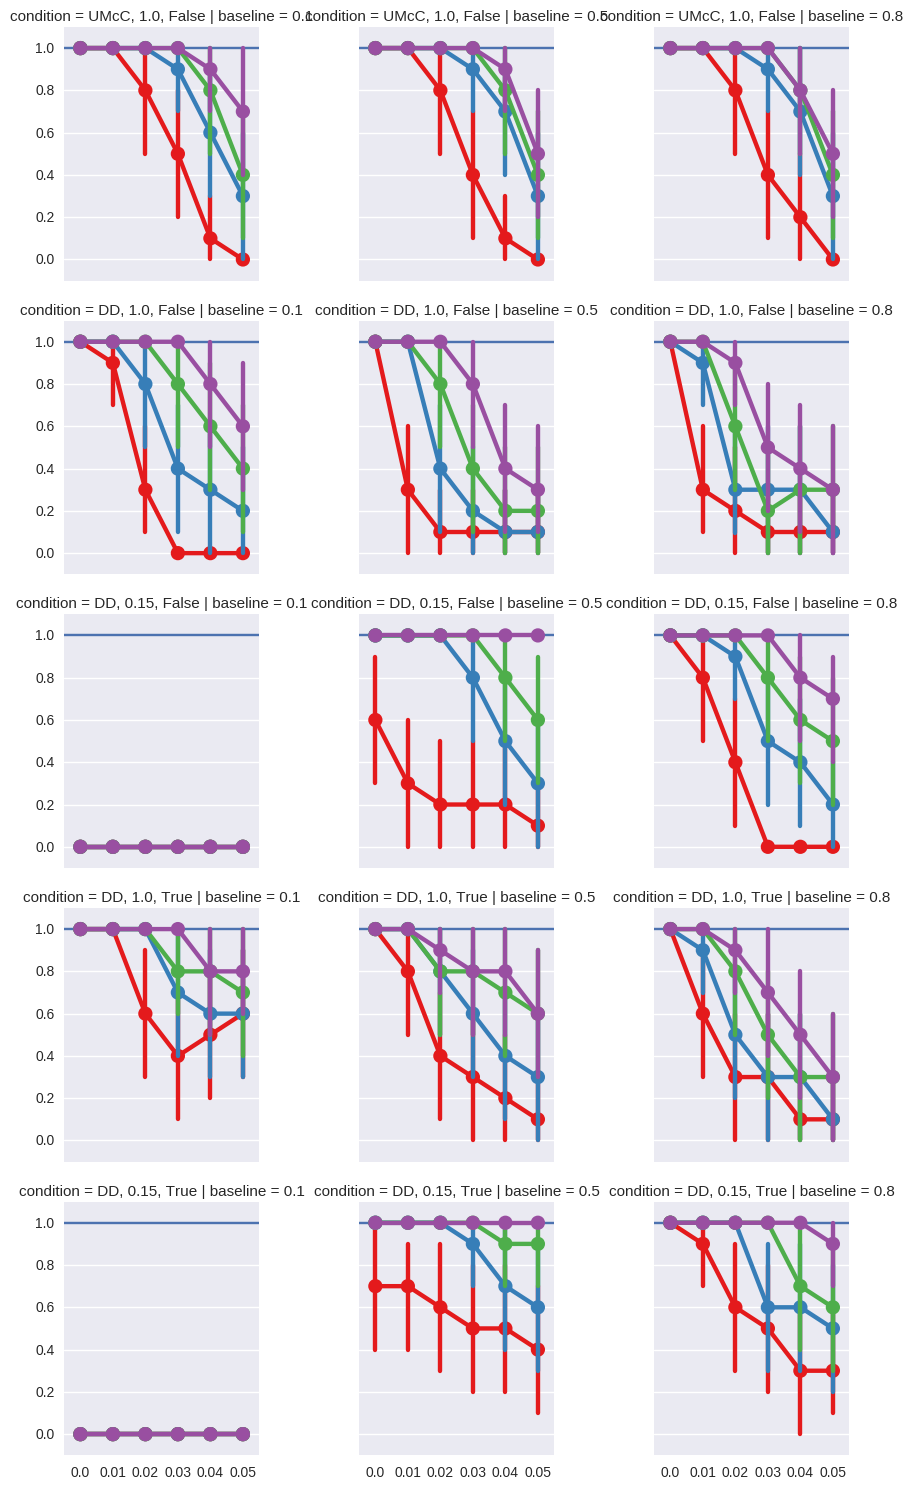

In [8]:
g = sns.FacetGrid(df, row='condition', col='baseline', row_order=cond_order)
g.map(sns.pointplot, 'noise', 'correct', 'target_sep', palette='Set1')
g.map(plt.axhline, y=1.)
g.set(ylim=(-0.1, 1.1))

# Error on winner output

Here we measure how much the winner deviates from 1 in the mean (including the winner from incorrect trials, but only trials were a decision was made). 

The Usher-McClelland network tends to exceed the target value slightly, except for a small target separation (0.05) where the output falls considerably below the target.

All drift diffusion variants are almost perfectly on target.

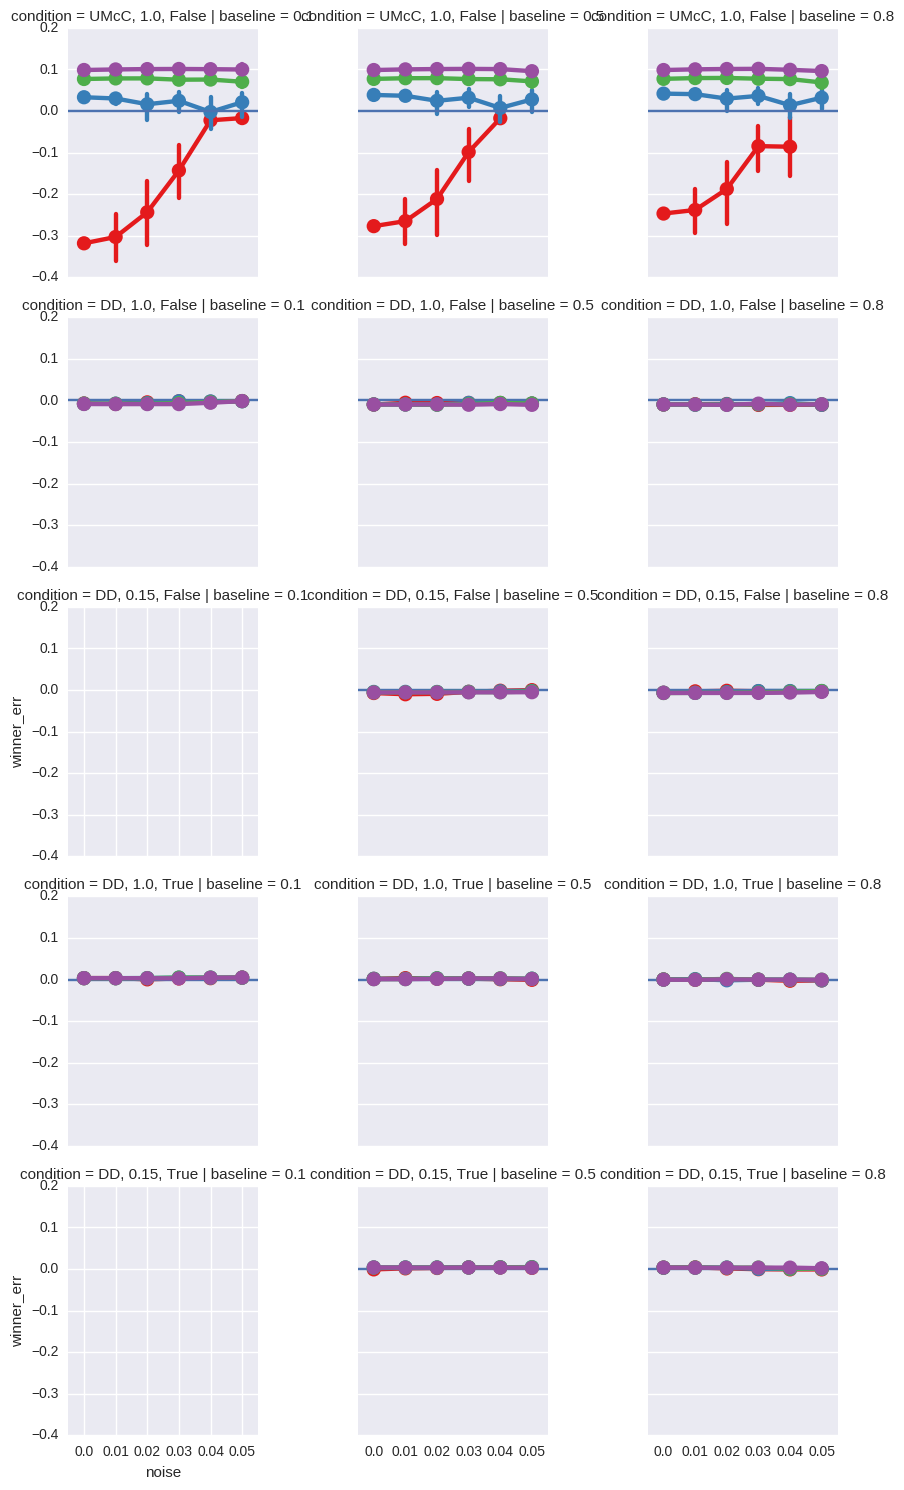

In [9]:
g = sns.FacetGrid(dfd, row='condition', col='baseline', row_order=cond_order)
g.map(sns.pointplot, 'noise', 'winner_err', 'target_sep', palette='Set1')
g.map(plt.axhline, y=0.)

# Runner up error

Not only the output value of the winner is important, but also the mean value of the 2nd place ("runner up"). This value should ideally be 0 the get a perfect separation.

This is what we find for the drift diffusion network. With the Usher-McClelland network, however, the separation degrades as noise increases.

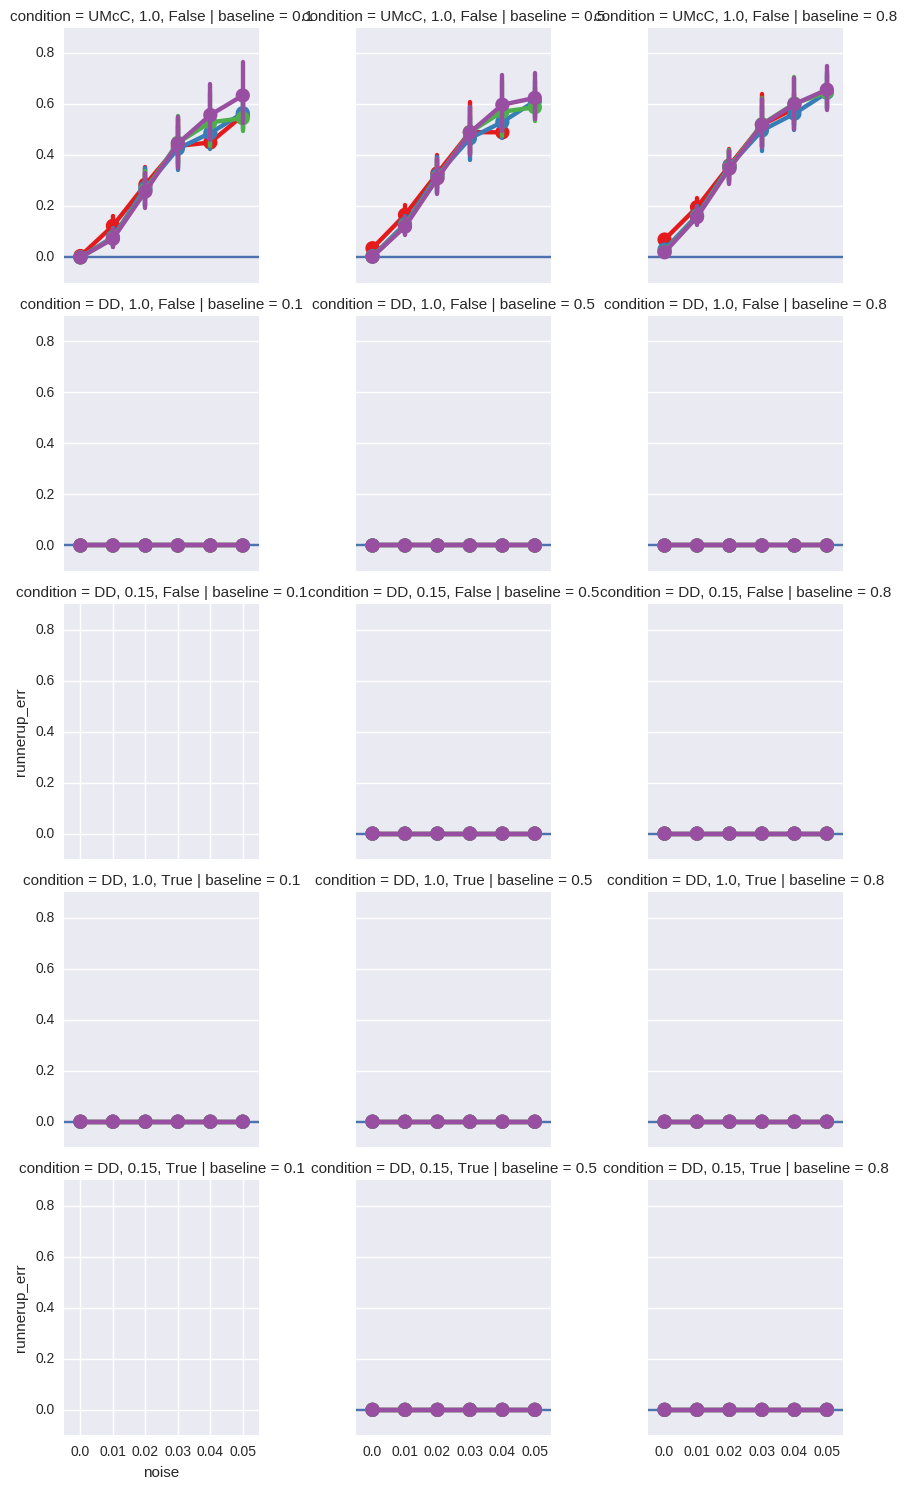

In [ ]:
g = sns.FacetGrid(dfd, row='condition', col='baseline', row_order=cond_order)
g.map(sns.pointplot, 'noise', 'runnerup_err', 'target_sep', palette='Set1')
g.map(plt.axhline, y=0.)

# Highest runner up error (transient response)

So far we only looked at the final output, but the output until a decision is made matters to. Ideally, the runner-up will never be above 0 in this time. The drift diffusion network is close to this behaviour. For larger baselines with some noise, we can get some runner-up activity, but it stays low. In contrast, the Usher-McClelland network produces large transient responses (even up to 1!) when noise is present. Embedded in a larger network this can be a problem because the transient output might be interpreted as the winner.

In [ ]:
g = sns.FacetGrid(dfd, row='condition', col='baseline', row_order=cond_order)
g.map(sns.pointplot, 'noise', 'runnerup_highest_err', 'target_sep', palette='Set1')
g.map(plt.axhline, y=0.)

# Timing

Decision speed can also be important. We plot the mean time until a decision has been reached using above's definition of a “decision”.

The time required to reach a decision increases for the Usher-McClelland network as the separation between the largest input and baseline decreases. It also slightly increases for higher noise.

In the drift diffusion network the decision time mainly depends on the largest input (which makes the reduced target separation appear relevant, but that is only because that reduces the value of the largest input) and the input scaling. Downscaling the input increases the decision time as it takes longer to integrate to the threshold (but also gives more time to average out noise).

In [ ]:
g = sns.FacetGrid(dfd, row='condition', col='baseline', row_order=cond_order)
g.map(sns.pointplot, 'noise', 't', 'target_sep', palette='Set1')
g.map(plt.axhline, y=0.)

# Further observations

* The Usher-McClelland network is mostly independent of the baseline.

# Conclusion

* The Usher-McClelland network is better at finding the correct winner in a short amount of time or if the input is continuously changing.
* The drift diffusion network is better if a guarantee is needed that a decision will eventually be reached (one could introduce a time limit for that decision by decreasing the threshold over time).
* The drift diffusion network is better if a clear output of a single winner is needed (non-winning output can remain active in the Usher-McClelland network).
* The drift diffusion network gives a signal that a decision has been reached for free. This is hard to determine in the Usher-McClelland network as even transient outputs can reach high values (even up to 1 with enough noise).